In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import itertools

import sklearn
import itertools

In [2]:
Ravdess_paths= np.array(("D:/archive/","D:/archive/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [4]:
print (len(ravdess_db))

2880


In [5]:
ravdess_db.sort_values(by='path',inplace=True)
ravdess_db.index =  range(len(ravdess_db.index))
ravdess_db.head(10)

path   source actor gender emotion  \
0  D:/archive/Actor_01/03-01-01-01-01-01-01.wav  Ravdess     1   male       1   
1  D:/archive/Actor_01/03-01-01-01-01-01-01.wav  Ravdess     1   male       1   
2  D:/archive/Actor_01/03-01-01-01-01-02-01.wav  Ravdess     1   male       1   
3  D:/archive/Actor_01/03-01-01-01-01-02-01.wav  Ravdess     1   male       1   
4  D:/archive/Actor_01/03-01-01-01-02-01-01.wav  Ravdess     1   male       1   
5  D:/archive/Actor_01/03-01-01-01-02-01-01.wav  Ravdess     1   male       1   
6  D:/archive/Actor_01/03-01-01-01-02-02-01.wav  Ravdess     1   male       1   
7  D:/archive/Actor_01/03-01-01-01-02-02-01.wav  Ravdess     1   male       1   
8  D:/archive/Actor_01/03-01-02-01-01-01-01.wav  Ravdess     1   male       2   
9  D:/archive/Actor_01/03-01-02-01-01-01-01.wav  Ravdess     1   male       2   

  emotion_lb  
0    neutral  
1    neutral  
2    neutral  
3    neutral  
4    neutral  
5    neutral  
6    neutral  
7    neutral  
8       calm  
9       calm

In [6]:
sampling_rate = 44100

In [7]:

filename = ravdess_db.path[0]
print (filename)


D:/archive/Actor_01/03-01-01-01-01-01-01.wav


In [8]:
samples, sample_rate = librosa.load(filename, res_type='kaiser_fast',sr=sampling_rate)
sample_rate, samples.shape

(44100, (145676,))

In [9]:
ipd.Audio(samples,rate=sample_rate)

## Spectogram

In [10]:
def log_specgram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

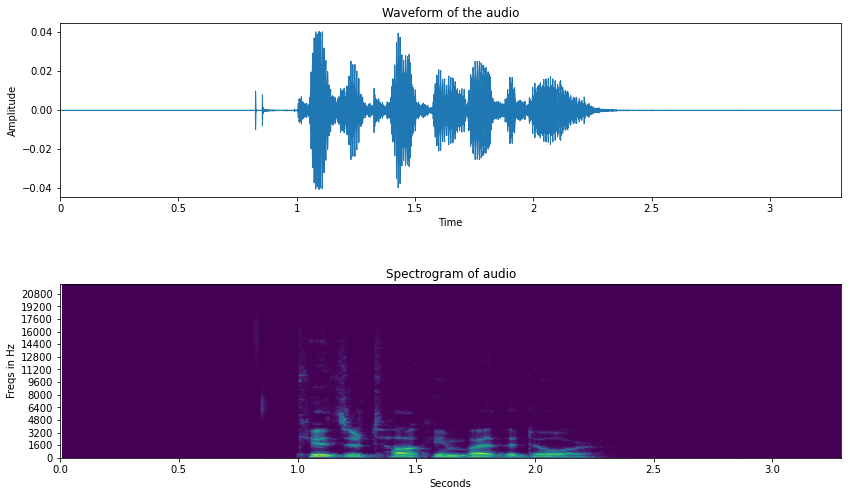

In [11]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Trimming the audio

In [12]:
samples_trim, index = librosa.effects.trim(samples,top_db=25)
samples_trim.shape, index

((55296,), array([44032, 99328]))

In [13]:
ipd.Audio(samples_trim,rate=sample_rate)

In [14]:
Difference_in_length = len(samples)-len(samples_trim)
Difference_in_length

90380

In [15]:
Difference_in_duration = librosa.get_duration(samples)-librosa.get_duration(samples_trim)
Difference_in_duration

4.098866213151927

Text(0.5, 0, 'Seconds')

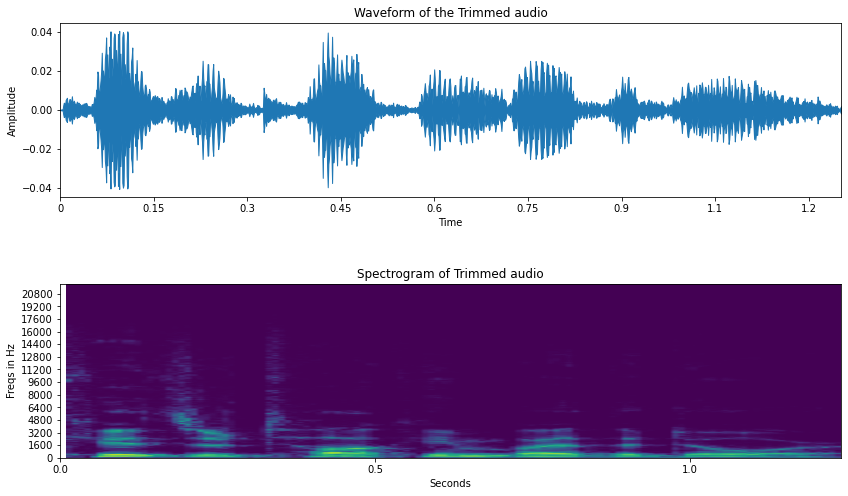

In [16]:
freqs, times, spectrogram = log_specgram(samples_trim, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples_trim, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Wiener Filter to remove Noise

In [17]:
sample_weiner = scipy.signal.wiener(samples_trim)
len(sample_weiner)

55296

In [18]:
ipd.Audio(sample_weiner,rate=sample_rate)

In [19]:
Diff_noise = sample_weiner-samples_trim
ipd.Audio(Diff_noise,rate=sample_rate)

Text(0.5, 0, 'Seconds')

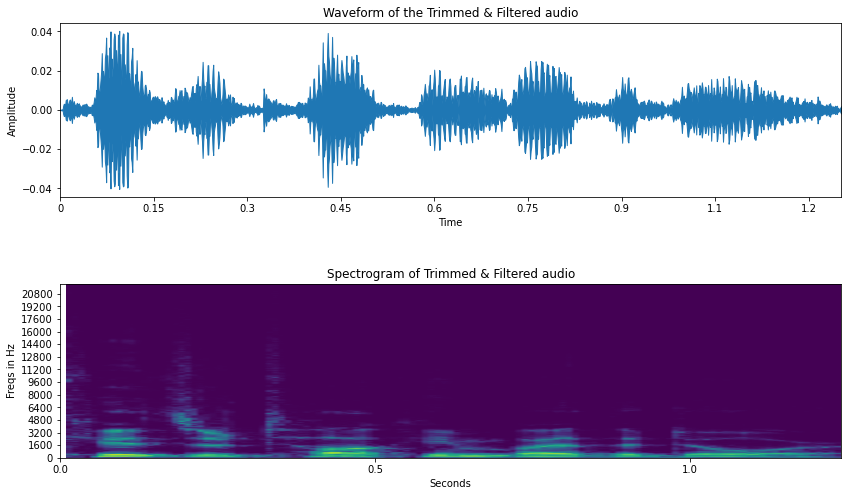

In [20]:
freqs, times, spectrogram = log_specgram(sample_weiner, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed & Filtered audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed & Filtered audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

##### waveform of noise

Text(0.5, 0, 'Seconds')

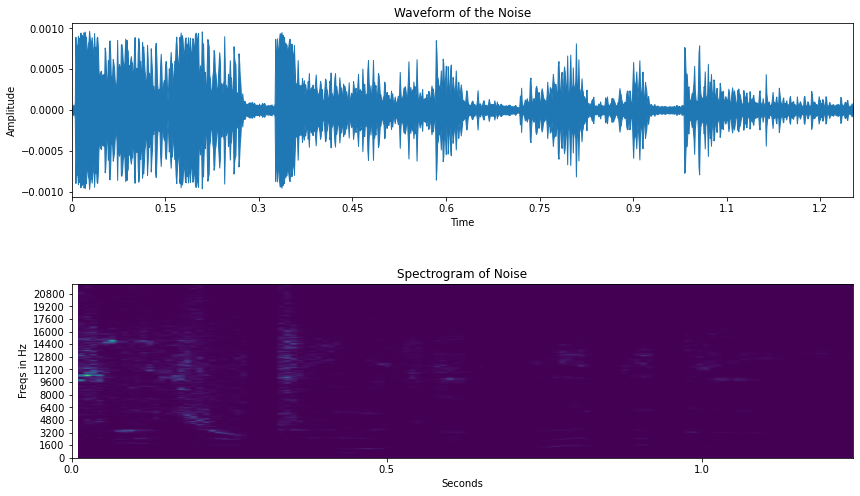

In [21]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(Diff_noise, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Noise')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(Diff_noise, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Noise')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# Feature Extraction

### Zero Crossing Rate

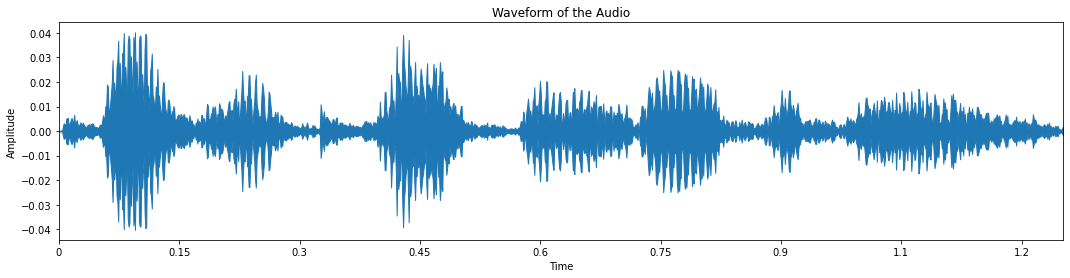

In [22]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
fig.subplots_adjust(hspace=.5)

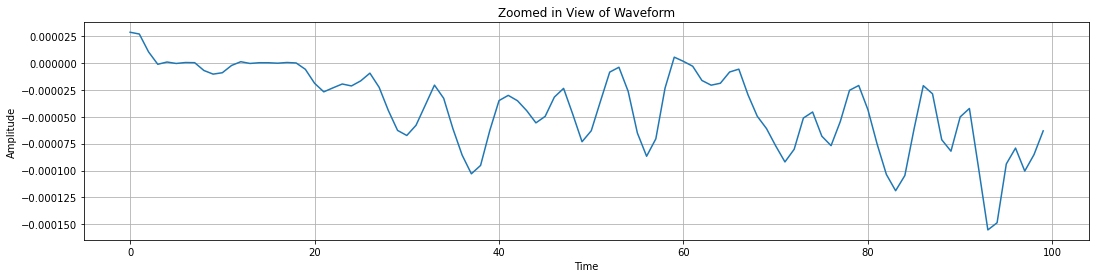

In [23]:
plt.figure(figsize=(18, 4))
plt.plot(sample_weiner[0:100])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Zoomed in View of Waveform")
plt.grid()

In [24]:
zero_crossings = librosa.zero_crossings(sample_weiner[0:100], pad=False)
print(sum(zero_crossings))

13


In [25]:
zero_crossings = librosa.zero_crossings(sample_weiner, pad=False)
print(sum(zero_crossings))

2168


## Frequency based Features
### MFCC

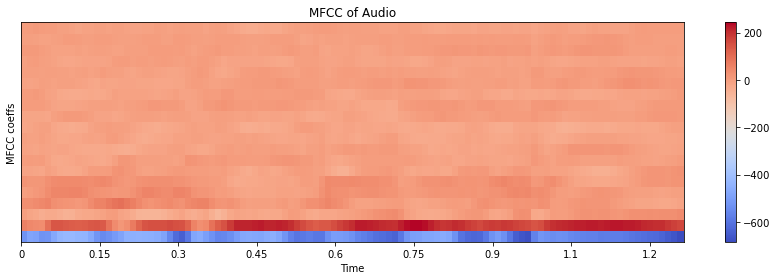

In [30]:
mfccs = librosa.feature.mfcc(sample_weiner, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC of Audio')
plt.colorbar()
plt.tight_layout()


In [31]:
Male_path = "D:/archive/Actor_09/03-01-05-01-01-01-09.wav"
Female_path = "D:/archive/Actor_08/03-01-05-01-01-01-08.wav"

In [32]:
#Male MFCCs
sample, sample_rate = librosa.load(Male_path, res_type='kaiser_fast',sr=22050*2)  
sample, index = librosa.effects.trim(sample,top_db=25)
sample =  scipy.signal.wiener(sample)

male_mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20)
mean_male_MFCC = np.mean(librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20), axis=0)

S_sample = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)
Male_Mel = librosa.amplitude_to_db(S_sample, ref=np.max)


#Female MFCCs
sample, sample_rate = librosa.load(Female_path, res_type='kaiser_fast',sr=22050*2)  
sample, index = librosa.effects.trim(sample,top_db=25)
sample =  scipy.signal.wiener(sample)

female_mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20)
mean_female_MFCC = np.mean(librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20), axis=0)
S_sample = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)
Female_Mel = librosa.amplitude_to_db(S_sample, ref=np.max)

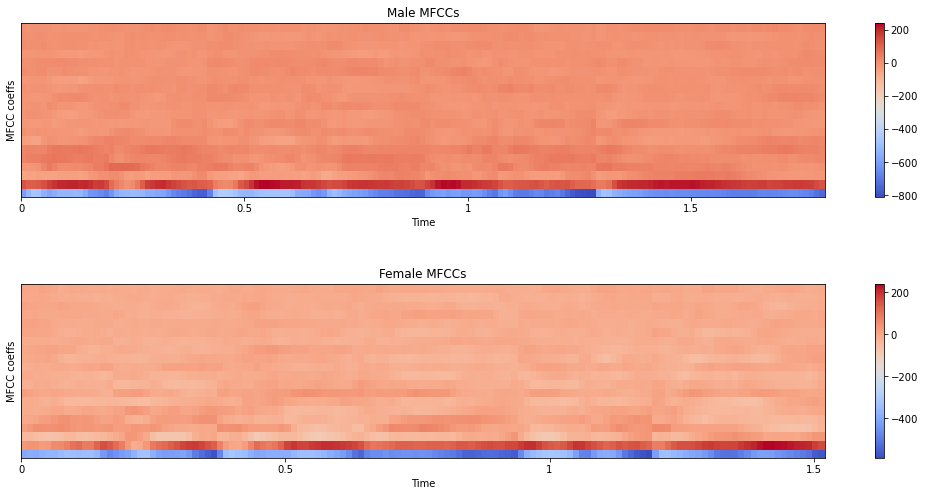

In [33]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(male_mfcc, sr=sample_rate, x_axis='time')
ax1.set_title('Male MFCCs')
ax1.set_ylabel('MFCC coeffs')
ax1.set_xlabel('Time')
plt.colorbar()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(female_mfcc, sr=sample_rate, x_axis='time')
ax2.set_title('Female MFCCs')
ax2.set_ylabel('MFCC coeffs')
ax2.set_xlabel('Time')

plt.colorbar()

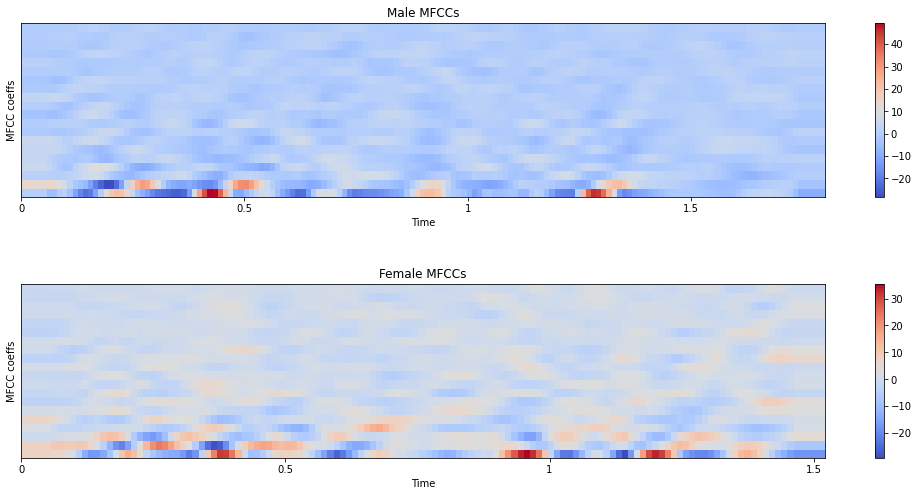

In [34]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(librosa.feature.delta(male_mfcc,order=1), sr=sample_rate, x_axis='time')
ax1.set_title('Male MFCCs')
ax1.set_ylabel('MFCC coeffs')
ax1.set_xlabel('Time')
plt.colorbar()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(librosa.feature.delta(female_mfcc,order=1), sr=sample_rate, x_axis='time')
ax2.set_title('Female MFCCs')
ax2.set_ylabel('MFCC coeffs')
ax2.set_xlabel('Time')

plt.colorbar()

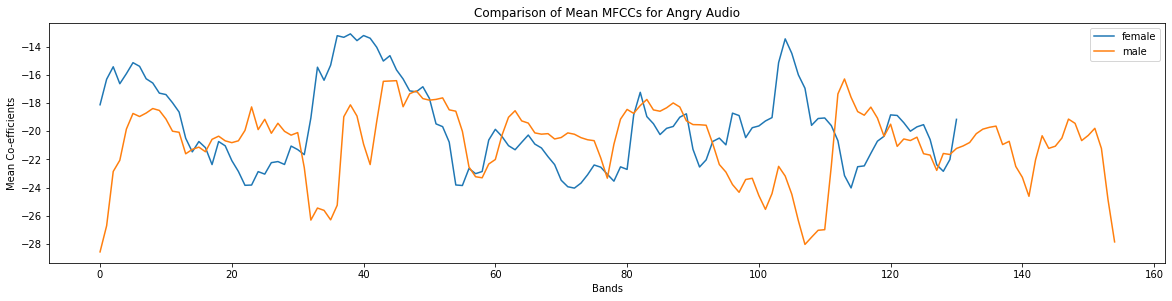

In [35]:
# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(mean_female_MFCC, label='female')
plt.plot(mean_male_MFCC, label='male')
plt.title('Comparison of Mean MFCCs for Angry Audio')
plt.xlabel('Bands')
plt.ylabel('Mean Co-efficients')
plt.legend()

### Mel Power Spectrogram

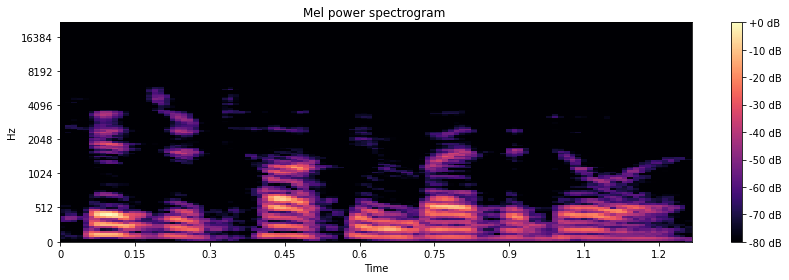

In [36]:
S_sample = librosa.feature.melspectrogram(sample_weiner, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S_sample = librosa.amplitude_to_db(S_sample, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S_sample, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

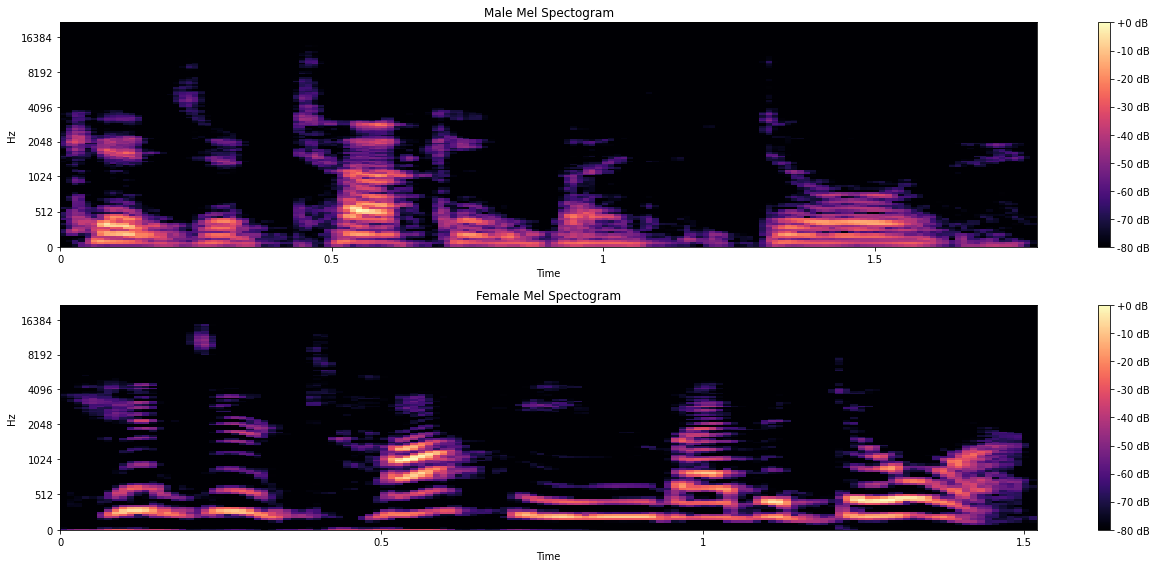

In [37]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(Male_Mel, sr=sample_rate, x_axis='time', y_axis='mel')
ax1.set_title('Male Mel Spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(Female_Mel,  sr=sample_rate, x_axis='time', y_axis='mel')
ax2.set_title('Female Mel Spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


### Chroma

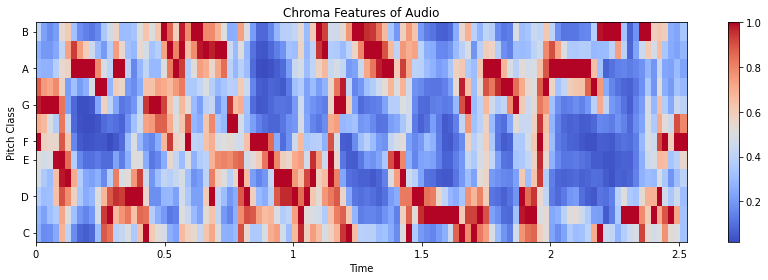

In [38]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(sample_weiner, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length,cmap='coolwarm')
plt.ylabel('Pitch Class')
plt.xlabel('Time')
plt.title('Chroma Features of Audio')
plt.colorbar()
plt.tight_layout()
#librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [39]:
Ravdess = "D:/archive/"


In [40]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotion                                          Path
0  neutral  D:/archive/Actor_01\03-01-01-01-01-01-01.wav
1  neutral  D:/archive/Actor_01\03-01-01-01-01-02-01.wav
2  neutral  D:/archive/Actor_01\03-01-01-01-02-01-01.wav
3  neutral  D:/archive/Actor_01\03-01-01-01-02-02-01.wav
4  neutral  D:/archive/Actor_01\03-01-02-01-01-01-01.wav

In [41]:

Ravdess_df.to_csv("data_path.csv",index=False)
Ravdess_df.shape

(1440, 2)

In [42]:
Ravdess_df.head(10)

Emotion                                          Path
0  neutral  D:/archive/Actor_01\03-01-01-01-01-01-01.wav
1  neutral  D:/archive/Actor_01\03-01-01-01-01-02-01.wav
2  neutral  D:/archive/Actor_01\03-01-01-01-02-01-01.wav
3  neutral  D:/archive/Actor_01\03-01-01-01-02-02-01.wav
4  neutral  D:/archive/Actor_01\03-01-02-01-01-01-01.wav
5  neutral  D:/archive/Actor_01\03-01-02-01-01-02-01.wav
6  neutral  D:/archive/Actor_01\03-01-02-01-02-01-01.wav
7  neutral  D:/archive/Actor_01\03-01-02-01-02-02-01.wav
8  neutral  D:/archive/Actor_01\03-01-02-02-01-01-01.wav
9  neutral  D:/archive/Actor_01\03-01-02-02-01-02-01.wav

# Data Visualisation and Exploration

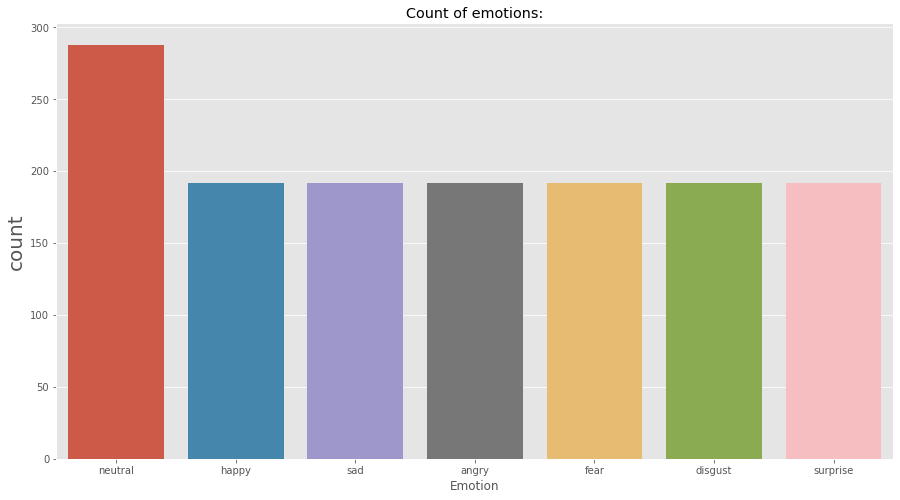

In [43]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
plt.style.use("ggplot")
plt.ylabel('Count', size=20)
plt.title("Count of emotions:")
sns.countplot(x=Ravdess_df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

# We can also plot waveplots and spectograms for audio signals.

In [44]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

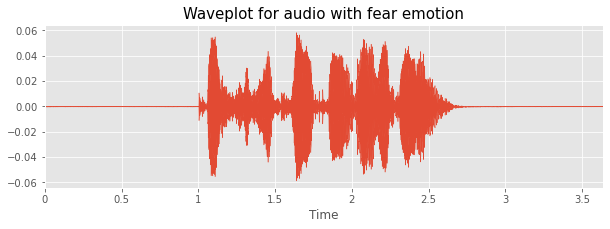

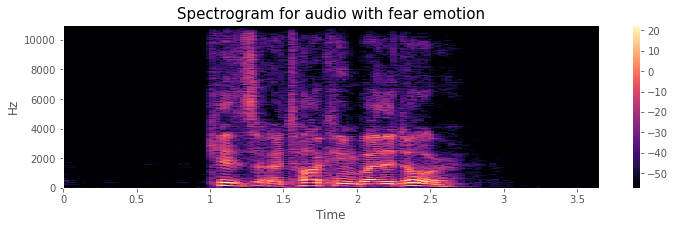

In [45]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

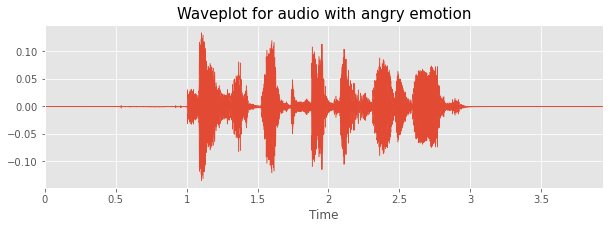

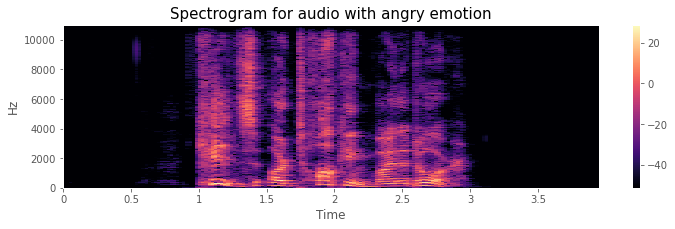

In [46]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

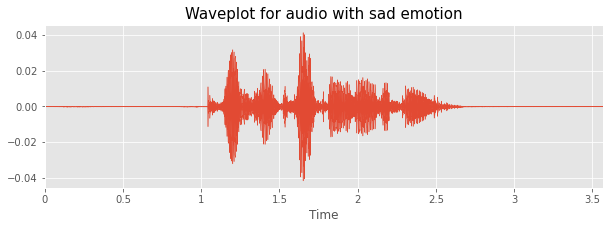

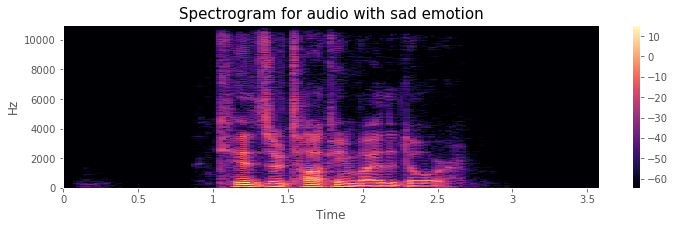

In [47]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [48]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [49]:
Ravdess_df.head()

Emotion                                          Path
0  neutral  D:/archive/Actor_01\03-01-01-01-01-01-01.wav
1  neutral  D:/archive/Actor_01\03-01-01-01-01-02-01.wav
2  neutral  D:/archive/Actor_01\03-01-01-01-02-01-01.wav
3  neutral  D:/archive/Actor_01\03-01-01-01-02-02-01.wav
4  neutral  D:/archive/Actor_01\03-01-02-01-01-01-01.wav

In [50]:
path = Ravdess_df[Ravdess_df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

#### 1. Simple Audio

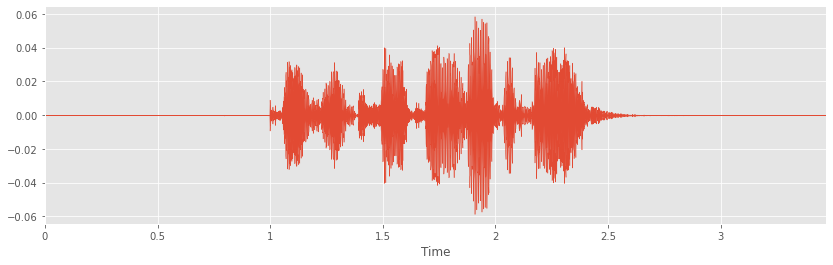

In [51]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

#### 2. Noise Injection

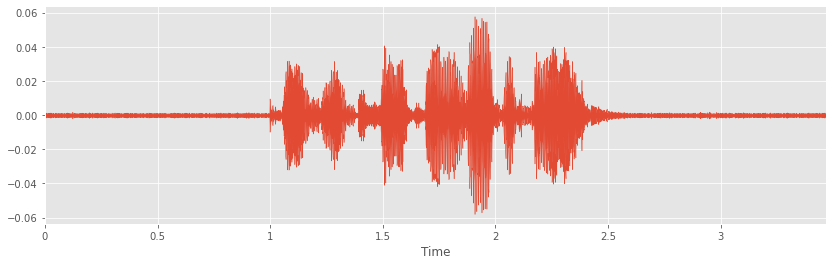

In [52]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

#### 3. Stretching

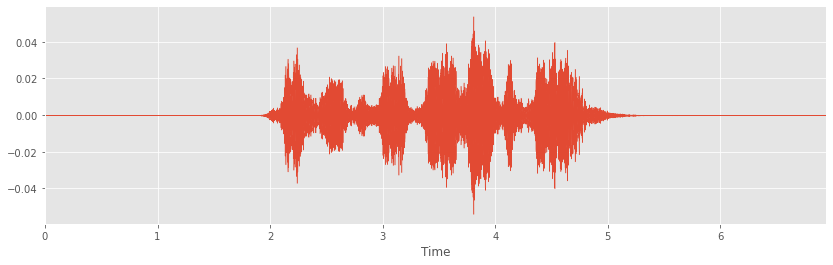

In [53]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

#### 4. Shifting

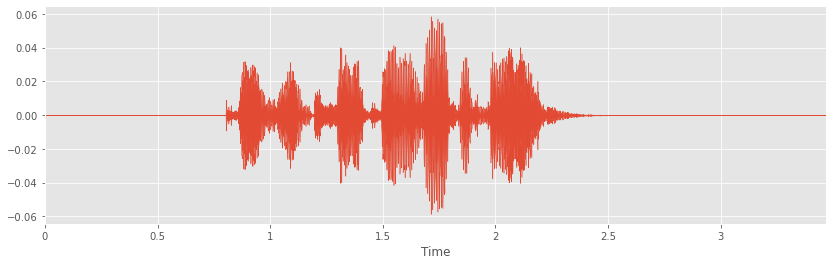

In [54]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

#### 5. Pitch

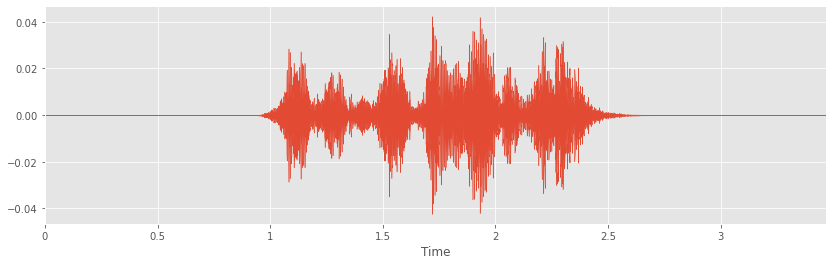

In [55]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

# Feature Extraction

In [56]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [57]:
path = np.array(Ravdess_df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

54458

In [58]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (107,)
Energy:  (107,)
Entropy of Energy : (107,)
RMS : (107,)
Spectral Centroid : (107,)
Spectral Flux:  ()
Spectral Rollof:  (107,)
Chroma STFT:  (1284,)
MelSpectrogram:  (13696,)
MFCC:  (2140,)


In [59]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        #spc(data, sr, frame_length, hop_length),
                        ##spc_entropy(data, sr),
                        ##spc_flux(data),
                        #spc_rollof(data, sr, frame_length, hop_length),
                        chroma_stft(data, sr, frame_length, hop_length),
                        mel_spc(data, sr, frame_length, hop_length, flatten=True),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [60]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [61]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(Ravdess_df.Path, Ravdess_df.Emotion, range(Ravdess_df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


In [62]:
features_path = "features.csv"

In [63]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.112305  0.171875  0.264160  0.356445  0.502441  0.590332  0.643555   
1  0.246094  0.370605  0.496582  0.517090  0.523438  0.526855  0.521484   
2  0.256348  0.369629  0.465332  0.420898  0.361816  0.328613  0.316895   
3  0.249023  0.373535  0.491211  0.493652  0.487793  0.482422  0.494141   
4  0.198242  0.338379  0.512207  0.595703  0.584473  0.603027  0.598145   

          7         8         9  ...     17705     17706     17707     17708  \
0  0.625977  0.555176  0.547363  ...  1.234354  1.208061  1.180838  1.152953   
1  0.517578  0.505371  0.500977  ...  3.864593 -0.765405  4.930262  0.874524   
2  0.381348  0.463867  0.538574  ...  0.424115  0.419951  0.415439  0.410598   
3  0.488281  0.490723  0.498047  ... -5.452870 -6.665553 -0.145797 -1.772560   
4  0.603516  0.642090  0.589844  ...  0.000000  0.000000  0.000000  0.000000   

      17709     17710     17711     17712     17713   labels  
0  1.124675  1.096260  1.067961  1.040004  1.012603  neutral  
1 -5.814918 -4.465358 -1.720827 -3.772334 -3.275033  neutral  
2  0.405429  0.399927  0.394135  0.388024  0.381614  neutral  
3 -3.098106 -2.462400 -2.828518  3.434730  8.111082  neutral  
4  0.000000  0.000000  0.000000  0.000000  0.000000  neutral  

[5 rows x 17715 columns]

In [64]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(5760, 17715)


In [65]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
17710     False
17711     False
17712     False
17713     False
labels    False
Length: 17715, dtype: bool


(5760, 17715)

In [66]:
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.112305  0.171875  0.264160  0.356445  0.502441  0.590332  0.643555   
1  0.246094  0.370605  0.496582  0.517090  0.523438  0.526855  0.521484   
2  0.256348  0.369629  0.465332  0.420898  0.361816  0.328613  0.316895   
3  0.249023  0.373535  0.491211  0.493652  0.487793  0.482422  0.494141   
4  0.198242  0.338379  0.512207  0.595703  0.584473  0.603027  0.598145   

          7         8         9  ...     17705     17706     17707     17708  \
0  0.625977  0.555176  0.547363  ...  1.234354  1.208061  1.180838  1.152953   
1  0.517578  0.505371  0.500977  ...  3.864593 -0.765405  4.930262  0.874524   
2  0.381348  0.463867  0.538574  ...  0.424115  0.419951  0.415439  0.410598   
3  0.488281  0.490723  0.498047  ... -5.452870 -6.665553 -0.145797 -1.772560   
4  0.603516  0.642090  0.589844  ...  0.000000  0.000000  0.000000  0.000000   

      17709     17710     17711     17712     17713   labels  
0  1.124675  1.096260  1.067961  1.040004  1.012603  neutral  
1 -5.814918 -4.465358 -1.720827 -3.772334 -3.275033  neutral  
2  0.405429  0.399927  0.394135  0.388024  0.381614  neutral  
3 -3.098106 -2.462400 -2.828518  3.434730  8.111082  neutral  
4  0.000000  0.000000  0.000000  0.000000  0.000000  neutral  

[5 rows x 17715 columns]

# Data Preparation

In [67]:
X = extracted_df.drop(labels="labels", axis=1)
y = extracted_df["labels"]

In [68]:
X.shape, y.shape

((5760, 17714), (5760,))

In [69]:
np.unique(y)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print((X_train.shape[0], X_test.shape[0]))

(4608, 1152)


In [71]:
from sklearn.svm import SVC

svclassifier = SVC(kernel = 'linear')

In [72]:
import time

starting_time = time.time()
svclassifier.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))

Trained model in 299.00538516044617 ms 


In [73]:
y_pred = svclassifier.predict(X_test)

              precision    recall  f1-score   support

       angry       0.70      0.77      0.73       158
     disgust       0.67      0.77      0.72       150
        fear       0.72      0.78      0.75       180
       happy       0.68      0.65      0.66       150
     neutral       0.80      0.81      0.81       204
         sad       0.78      0.62      0.69       160
    surprise       0.79      0.71      0.75       150

    accuracy                           0.73      1152
   macro avg       0.73      0.73      0.73      1152
weighted avg       0.74      0.73      0.73      1152

----accuracy score 73.4375 ----


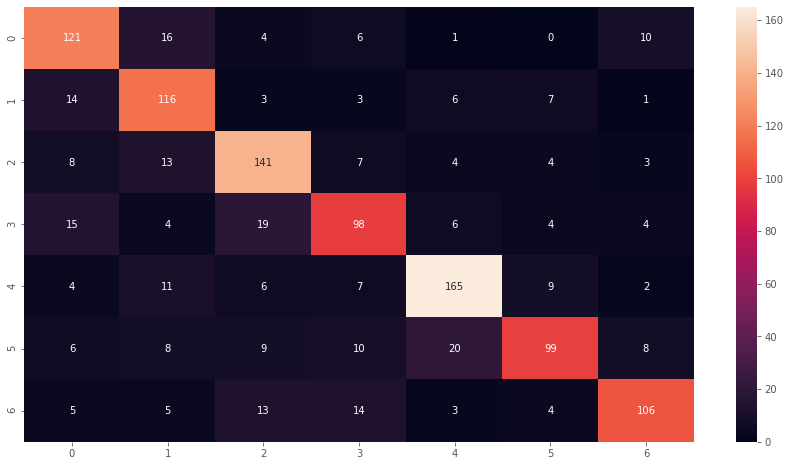

In [74]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [75]:
train_acc = float(svclassifier.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 100.0 ----
----test accuracy score 73.4375 ----


### Cross Validation

In [76]:
from sklearn.model_selection import cross_val_score

# no. of folds cv = 5
cv_results = cross_val_score(svclassifier, X, y, cv = 5)
print(cv_results)

[0.41059028 0.44357639 0.390625   0.4140625  0.37760417]


### Scaling

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


#splitting dataset into train/ test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: svc_scaled
svc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7899305555555556
Accuracy without Scaling: 0.7335069444444444


In [78]:
train_acc = float(svc_scaled.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svc_scaled.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 88.4765625 ----
----test accuracy score 78.99305555555556 ----


In [79]:
scaled_predictions = svc_scaled.predict(X_test)

              precision    recall  f1-score   support

       angry       0.78      0.80      0.79       153
     disgust       0.82      0.91      0.86       172
        fear       0.93      0.60      0.73       141
       happy       0.78      0.73      0.76       124
     neutral       0.74      0.92      0.82       253
         sad       0.78      0.61      0.68       155
    surprise       0.81      0.83      0.82       154

    accuracy                           0.79      1152
   macro avg       0.81      0.77      0.78      1152
weighted avg       0.80      0.79      0.79      1152

----accuracy score 78.99305555555556 ----


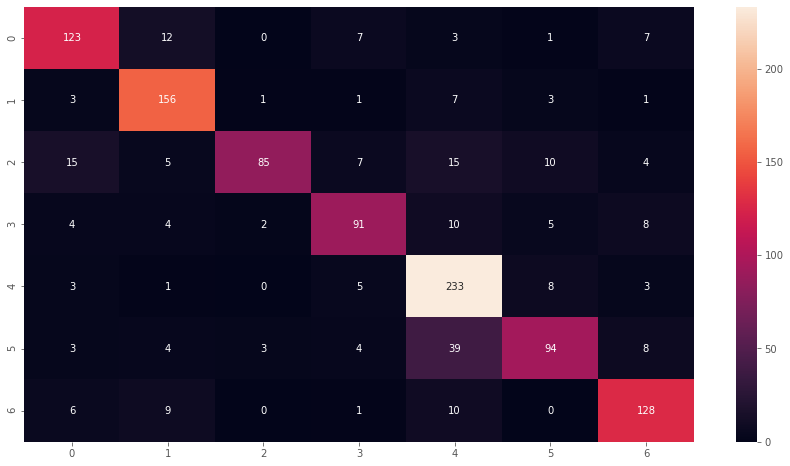

In [80]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,scaled_predictions))

acc = float(accuracy_score(y_test,scaled_predictions))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,scaled_predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [81]:
df=pd.DataFrame({'Actual': y_test, 'Predicted':scaled_predictions})
df

Actual Predicted
5542  neutral   neutral
883      fear      fear
5534  neutral   neutral
1779      sad       sad
4454    angry     angry
...       ...       ...
1968    happy   neutral
1836     fear      fear
4103  neutral   neutral
2193  neutral   neutral
2062    angry     angry

[1152 rows x 2 columns]

## Random Forest

In [82]:
X.shape, y.shape

((5760, 17714), (5760,))

In [83]:
print((X_train.shape[0], X_test.shape[0]))

(4608, 1152)


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
  
 # create regressor object 
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
classifier.fit(X_train, y_train)   

c_p = classifier.predict(X_test) 


print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
# creating a confusion matrix 
print(confusion_matrix(y_test,c_p) )

0.8324652777777778
              precision    recall  f1-score   support

       angry       0.82      0.88      0.85       153
     disgust       0.85      0.87      0.86       172
        fear       0.90      0.74      0.81       141
       happy       0.82      0.81      0.81       124
     neutral       0.79      0.93      0.86       253
         sad       0.92      0.72      0.81       155
    surprise       0.80      0.80      0.80       154

    accuracy                           0.83      1152
   macro avg       0.84      0.82      0.83      1152
weighted avg       0.84      0.83      0.83      1152

[[134   4   1   1   3   1   9]
 [  5 150   1   2  10   2   2]
 [ 11   4 105   3  10   4   4]
 [  3   0   7 100   8   1   5]
 [  0   7   0   7 235   1   3]
 [  2   9   1   6  17 112   8]
 [  9   3   2   3  13   1 123]]


In [85]:
from sklearn.ensemble import RandomForestClassifier
  
 # create regressor object 
classifier = RandomForestClassifier(n_estimators = 20,random_state = 0) 
  
# fit the regressor with x and y data 
classifier.fit(X_train, y_train)   

c_p = classifier.predict(X_test) 


print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
# creating a confusion matrix 
print(confusion_matrix(y_test,c_p) )

0.7743055555555556
              precision    recall  f1-score   support

       angry       0.77      0.82      0.80       153
     disgust       0.78      0.84      0.81       172
        fear       0.80      0.70      0.75       141
       happy       0.65      0.73      0.69       124
     neutral       0.79      0.87      0.83       253
         sad       0.82      0.63      0.71       155
    surprise       0.79      0.75      0.77       154

    accuracy                           0.77      1152
   macro avg       0.77      0.76      0.76      1152
weighted avg       0.78      0.77      0.77      1152

[[126   6   0  10   3   1   7]
 [  6 144   0   4  11   3   4]
 [ 12   4  98   5   8   7   7]
 [  8   2   9  91   5   3   6]
 [  1  12   4   8 221   5   2]
 [  3  14   3  13  20  97   5]
 [  7   3   8   8  11   2 115]]


In [86]:
df=pd.DataFrame({'Actual': y_test, 'Predicted':c_p})
df

Actual Predicted
5542  neutral   neutral
883      fear      fear
5534  neutral   neutral
1779      sad       sad
4454    angry     angry
...       ...       ...
1968    happy     happy
1836     fear      fear
4103  neutral   neutral
2193  neutral   disgust
2062    angry     angry

[1152 rows x 2 columns]